In [1]:
import polars as pl
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "data/20240626_3.csv"
DELAY_TIME = 50 # ns(+)

メタデータの取得

In [3]:
meta = pl.read_csv(DATA_PATH)[:11]
meta

Model,MSO44
str,str
"""Label""",null
"""Waveform Type""","""ANALOG"""
"""Horizontal Units""","""s"""
"""Sample Interval""","""8.00000000e-10"""
"""Record Length""","""50000"""
…,…
"""Vertical Units""","""V"""
"""FastFrame Count""","""625"""
"""ANALOG_Thumbnail""",null


In [4]:
record_len = int(meta.filter(pl.col("Model") == "Record Length")[0,1])
fastframe_count = int(meta.filter(pl.col("Model") == "FastFrame Count")[0,1])

In [5]:
record_len

50000

In [6]:
fastframe_count

625

実データの分割

In [7]:
df_all = pl.read_csv(DATA_PATH, skip_rows=14)
df_all

TIME,CH1
f64,f64
-0.000038,0.000336
-0.000038,0.000592
-0.000038,0.00047
-0.000038,0.000875
-0.000038,0.000369
…,…
0.000002,-0.000006
0.000002,0.000277
0.000002,0.000216


In [8]:
muon_dfs = []
electon_dfs = []
for i in range(fastframe_count):
    # DELAY_TIMEを引いておく
    muon_dfs.append(df_all[i*record_len:(i+1)*record_len].filter(pl.col("TIME") < -DELAY_TIME*1e-9))
    electon_dfs.append(df_all[i*record_len:(i+1)*record_len].filter(pl.col("TIME") >= -DELAY_TIME*1e-9))

In [9]:
muon_dfs[0]

TIME,CH1
f64,f64
-0.000038,0.000336
-0.000038,0.000592
-0.000038,0.00047
-0.000038,0.000875
-0.000038,0.000369
…,…
-5.3230e-8,0.0004625
-5.2430e-8,-0.000052
-5.1630e-8,0.000211


In [10]:
# TIMEが同じか確認
muon_dfs[1]

TIME,CH1
f64,f64
-0.000038,-0.000028
-0.000038,0.000605
-0.000038,0.000452
-0.000038,-0.000089
-0.000038,0.000489
…,…
-5.3230e-8,-0.000072
-5.2430e-8,0.00008
-5.1630e-8,0.000342


In [11]:
# DELAY_TIMEから始まっているか確認
electon_dfs[0]

TIME,CH1
f64,f64
-4.9230e-8,0.000186
-4.8430e-8,0.000455
-4.7630e-8,0.000033
-4.6830e-8,0.000105
-4.6030e-8,0.000028
…,…
0.000002,-0.000095
0.000002,0.000117
0.000002,0.00023


DELAY_TIMEより後のときのプロット(電子)

In [12]:
def plot_waveforms(dfs:list, ax,):
    for i in range(len(dfs)):
        ax.plot(dfs[i]["TIME"]*10**6, dfs[i]["CH1"]*10**3)
    ax.set_xlabel(r"Time ($\mu $s)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()

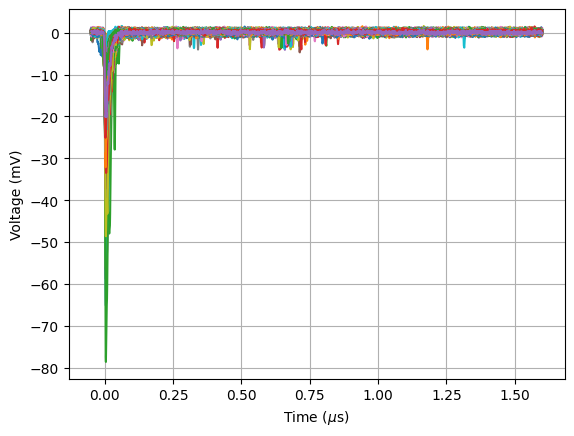

In [13]:
fig, ax = plt.subplots()
plot_waveforms(electon_dfs, ax)
plt.show()

DELAY_TIMEより前のときのプロット（ミューオン）

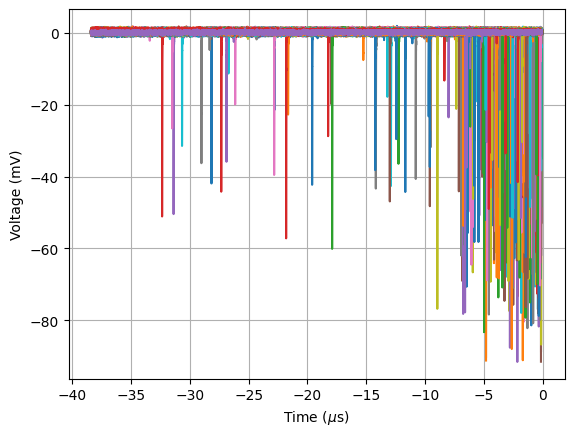

In [14]:
fig, ax = plt.subplots()
plot_waveforms(muon_dfs, ax)
plt.show()

電圧が最小値周辺の領域の取得

In [15]:
# 1つの波形を取り出すための範囲
WIDTH = 150

In [16]:
# 最小
def getMinDataframe(df: pl.DataFrame, is_electon: bool):
    if is_electon: # 電子の信号
        minIndex = 0
    else:
        minIndex = df["CH1"].arg_min()
        if minIndex == None:
            print("No minimum value")
            print(df)
            return None
    length = df.shape[0]
    minRange = [minIndex-WIDTH, minIndex+WIDTH]
    if minRange[0] < 0:
        minRange[0] = 0
    if minRange[1] > length:
        minRange[1] = length
    return df[minRange[0]:minRange[1]]

In [17]:
min_muon_dfs = []
min_electon_dfs = []

for i in range(fastframe_count):
    min_muon_dfs.append(getMinDataframe(muon_dfs[i], is_electon=False))
    min_electon_dfs.append(getMinDataframe(electon_dfs[i], is_electon=True))

In [18]:
min_muon_dfs[7]

TIME,CH1
f64,f64
-0.000002,-0.000097
-0.000002,0.000455
-0.000002,0.00017
-0.000002,0.000108
-0.000002,0.00015
…,…
-0.000002,0.000303
-0.000002,0.000209
-0.000002,-0.000153


In [19]:
muon_dfs[7]

TIME,CH1
f64,f64
-0.000038,-0.000033
-0.000038,-0.000536
-0.000038,-0.000345
-0.000038,-0.000041
-0.000038,0.000267
…,…
-5.3600e-8,0.000244
-5.2800e-8,-0.000106
-5.2000e-8,0.000134


In [20]:
def plot_waveform(df, ax):
    ax.plot(df["TIME"]*10**6, df["CH1"]*10**3)
    ax.set_xlabel(r"Time ($\mu $s)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()

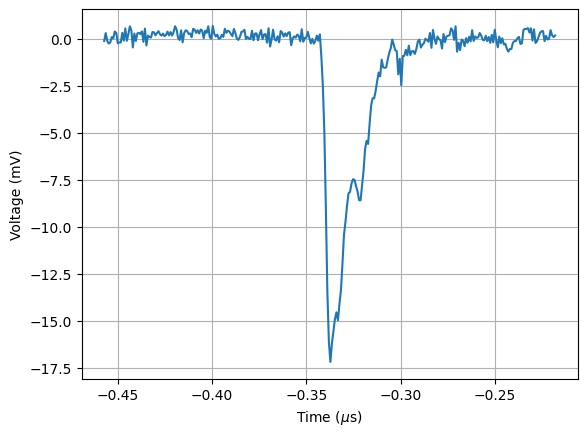

In [21]:
num = 1

fig, ax = plt.subplots()
plot_waveform(min_muon_dfs[num], ax)
plt.show()

ある関数でフィッテング

In [22]:
def fitfunc(t, A, B, C, T):
    t = np.array(t)
    return np.where(t < T, C, -A*np.exp(-B*(t-T))+C)

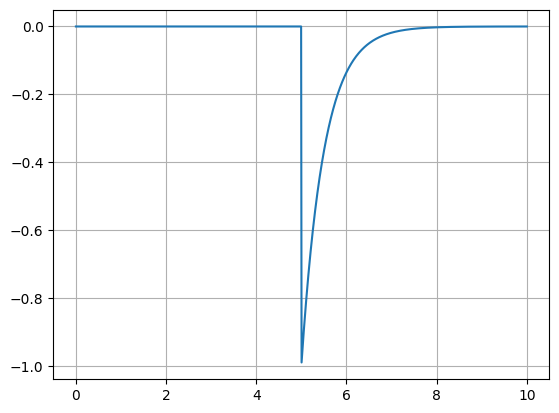

In [23]:
# 関数の確認
x = np.linspace(0, 10, 1000)
y = fitfunc(x, 1, 2, 0, 5)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
plt.show()

In [24]:
muon_dfs[1]["TIME"].to_numpy()

array([-3.839963e-05, -3.839883e-05, -3.839803e-05, ..., -5.163000e-08,
       -5.083000e-08, -5.003000e-08])

In [25]:
def fiting(df: pl.DataFrame, f, is_electon: bool):
    maxfev = 1000000  # 最大反復回数を増やす
    time = df["TIME"].to_numpy()
    ch1 = df["CH1"].to_numpy()
    
    # NaNとinfを削除
    mask = ~np.isnan(time) & ~np.isnan(ch1) & ~np.isinf(time) & ~np.isinf(ch1)
    time = time[mask]
    ch1 = ch1[mask]
    
    # 初期パラメータの調整
    A_init = ch1.min()
    C_init = 0
    if is_electon:
        B_init = 6e7 # ここの値は微調整が必要
        T_init = 0
    else:
        B_init = 1e8 # ここの値は微調整が必要   
        T_init = time[ch1.argmin()]
    init = [A_init, B_init, C_init, T_init]
    
    bounds = ([-1, 0, -1, time.min()], [np.inf, np.inf, 1, time.max()])
    
    try:
        popt, pcov = curve_fit(f, time, ch1, p0=init, bounds=bounds, maxfev=maxfev)
    except RuntimeError as e:
        print(f"Fit did not converge: {e}")
    return popt, pcov, mask

ミューオンのフィッティング

In [26]:
muon_popts = []
muon_pcovs = []
muon_masks = []

for i in range(fastframe_count):
    popt, pcov, mask = fiting(min_muon_dfs[i], fitfunc, is_electon=False)
    muon_popts.append(popt)
    muon_pcovs.append(pcov)
    muon_masks.append(mask)
muon_popts

[array([ 8.35321512e-02,  7.17910641e+07,  8.75400952e-05, -1.34587106e-06]),
 array([ 2.08115708e-02,  7.07100673e+07, -3.02750640e-06, -3.39365852e-07]),
 array([ 3.84836453e-02,  5.23705381e+07,  1.98442955e-04, -1.22583223e-05]),
 array([ 4.31681317e-02,  7.12122109e+07, -3.88486578e-04, -2.99764007e-07]),
 array([ 5.95359354e-02,  6.78728934e+07,  1.11222512e-04, -3.13854691e-05]),
 array([ 8.27741214e-02,  6.97452458e+07,  1.74938479e-04, -6.81556568e-06]),
 array([ 1.74101885e-02,  7.55381766e+07,  7.18335241e-05, -4.01776916e-07]),
 array([ 6.99070121e-02,  7.11447259e+07,  1.53386494e-04, -1.82068384e-06]),
 array([ 3.56737071e-02,  5.73924551e+07,  3.79017721e-04, -4.11681682e-06]),
 array([ 6.53310539e-02,  6.46995803e+07,  2.85833396e-04, -6.62966045e-06]),
 array([ 4.32346293e-02,  6.29814408e+07,  3.12424709e-04, -1.38125290e-06]),
 array([ 8.46666123e-02,  8.07093456e+07, -2.04478344e-04, -5.52725432e-07]),
 array([ 2.60500314e-02,  6.99321550e+07,  1.81447288e-04, -1.90

電子のフィッテング

In [27]:
electon_popts = []
electon_pcovs = []
electon_masks = []

for i in range(fastframe_count):
    popt, pcov, mask = fiting(min_electon_dfs[i], fitfunc, is_electon=True)
    electon_popts.append(popt)
    electon_pcovs.append(pcov)
    electon_masks.append(mask)
electon_popts

[array([ 3.47468223e-02,  7.33873456e+07, -7.37917943e-04,  6.72084674e-10]),
 array([ 3.35984275e-02,  7.41273455e+07, -4.60319500e-04,  5.81735680e-10]),
 array([ 3.13396786e-02,  5.27484232e+07, -5.77534654e-03,  4.26168243e-09]),
 array([ 4.59639044e-02,  7.09541480e+07, -7.05932559e-04,  1.01595775e-09]),
 array([ 1.90770136e-02,  7.14651127e+07, -1.68400602e-04, -1.25568578e-10]),
 array([ 2.36182229e-02,  7.72402086e+07, -2.21652478e-04,  4.22013505e-10]),
 array([ 4.37856966e-02,  7.00008473e+07, -3.73078535e-04,  9.47919074e-10]),
 array([ 1.45919932e-02,  6.70329863e+07,  5.51002462e-05, -5.62970604e-10]),
 array([ 4.50479765e-02,  7.16829911e+07, -3.96938146e-04,  1.06091673e-09]),
 array([ 3.78472987e-02,  6.26207472e+07, -6.28619231e-05,  7.94238848e-10]),
 array([ 1.52164073e-02,  7.23750261e+07,  1.82818815e-04, -2.28521206e-09]),
 array([ 2.52831667e-02,  6.69809548e+07,  4.83689737e-04, -8.36042239e-10]),
 array([ 1.69823823e-02,  6.04517440e+07,  1.79938199e-04, -9.25

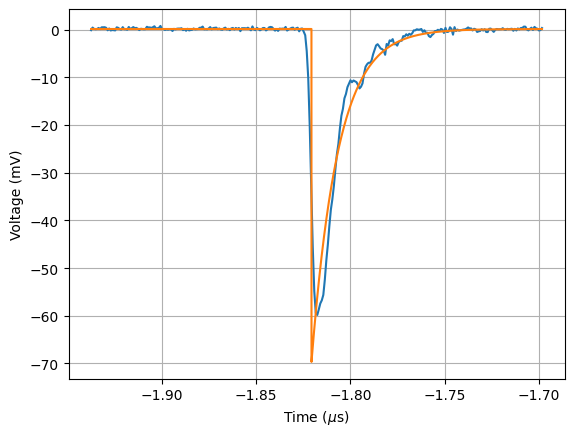

In [28]:
# ミューオンのフィッテング結果
num = 7
plus_x = 0 # 1e-8 # 範囲指定

fig, ax = plt.subplots()
x = np.linspace(min_muon_dfs[num]["TIME"].min(), min_muon_dfs[num]["TIME"].max()+plus_x, 10000)
plot_waveform(min_muon_dfs[num], ax)
ax.plot(x*10**6, fitfunc(x, *muon_popts[num])*10**3)
plt.show()

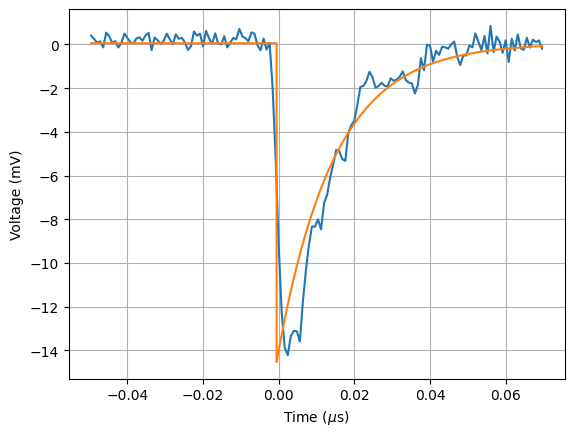

In [29]:
# 電子のフィッテング結果
fig, ax = plt.subplots()
x = np.linspace(min_electon_dfs[num]["TIME"].min(), min_electon_dfs[num]["TIME"].max()+plus_x, 10000)
plot_waveform(min_electon_dfs[num], ax)
ax.plot(x*10**6, fitfunc(x, *electon_popts[num])*10**3)
plt.show()

ミューオンの寿命

In [30]:
def get_deltaT(muon_popts, electon_popts):
    deltaT = []
    for i in range(fastframe_count):
        electonT = electon_popts[i][3]
        muonT = muon_popts[i][3]
        deltaT.append(electonT - muonT)
    return deltaT

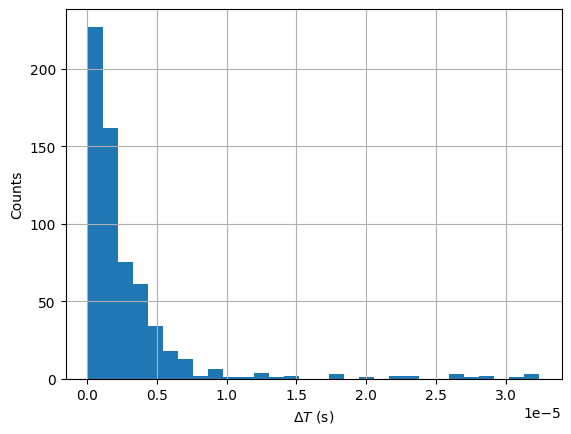

In [40]:
bin_num = 30
fig, ax = plt.subplots()
deltaT = get_deltaT(muon_popts, electon_popts)
ax.hist(deltaT, bins=bin_num)
ax.set_xlabel(r"$\Delta T$ (s)")
ax.set_ylabel("Counts")
ax.grid()
plt.show()

バックグラウンドの除去せずにミューオンの寿命の測定

In [32]:
def getBinCount(deltaT, bin_num):
    max_deltaT = max(deltaT)
    bin_width = np.arange(0, max_deltaT, max_deltaT/bin_num)
    count, time = np.histogram(deltaT, bins=bin_width)
    centerTime = (time[:-1] + time[1:]) / 2
    return count, centerTime

In [1]:
deltaT_count, deltaT_time = getBinCount(deltaT, bin_num)


# 0の値を削除
mask = np.where(deltaT_count == 0, False, True)
mask
deltaT_count = deltaT_count[mask]
deltaT_time = deltaT_time[mask]

# deltaTがある値以上のものを削除(非推奨)
limT = 0.8e-5
mask = np.where(deltaT_time > limT, False, True)
deltaT_count = deltaT_count[mask]
deltaT_time = deltaT_time[mask]

# 対数をとることで線形に
log_deltaT_count = np.log(deltaT_count)

model = LinearRegression()
model.fit(deltaT_time.reshape(-1, 1), log_deltaT_count)
a = model.coef_[0]
b = model.intercept_

tau = -1/a
N_0 = np.exp(b)

NameError: name 'getBinCount' is not defined

In [2]:
fig, ax = plt.subplots()
ax.plot(deltaT_time, deltaT_count, "o")
ax.plot(deltaT_time, N_0*np.exp(a*deltaT_time))
ax.set_yscale("log")
ax.set_xlabel(r"$\Delta T$ (s)")
ax.set_ylabel("Count")
ax.grid()

NameError: name 'plt' is not defined

In [53]:
print(rf"tau: {float(tau)*1e6:.2f} us")

tau: 2.02 us


面積(総電荷量)の測定

In [ ]:
def S(popt):
    A, B, _, _ = popt
    return A/B

In [ ]:
muon_S = []
electon_S = []
for i in range(fastframe_count):
    muon_S.append(S(muon_popts[i]))
    electon_S.append(S(electon_popts[i]))
muon_S

[np.float64(1.1635452431662384e-09),
 np.float64(2.943225994674964e-10),
 np.float64(7.348338717261322e-10),
 np.float64(6.061900215469856e-10),
 np.float64(8.771680774345591e-10),
 np.float64(1.186806647732285e-09),
 np.float64(2.304819800440021e-10),
 np.float64(9.826028738651173e-10),
 np.float64(6.215748584556879e-10),
 np.float64(1.0097600879838286e-09),
 np.float64(6.864661825285835e-10),
 np.float64(1.0490310836939445e-09),
 np.float64(3.7250434197205824e-10),
 np.float64(5.997175722002637e-10),
 np.float64(4.73685740051769e-10),
 np.float64(1.0669633333084705e-09),
 np.float64(5.699103580782061e-10),
 np.float64(9.116924919692667e-10),
 np.float64(1.0680101161561798e-09),
 np.float64(9.892910388946045e-10),
 np.float64(6.141903723615621e-10),
 np.float64(1.904903867623055e-10),
 np.float64(4.0075159234927916e-10),
 np.float64(8.05273272901732e-10),
 np.float64(1.1442009224978567e-09),
 np.float64(5.752433764885404e-10),
 np.float64(1.3776981420312773e-09),
 np.float64(7.1305970